In [1]:
import warnings
import numpy as np
import pandas as pd
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
store = pd.read_csv('../data/store.csv')
train = pd.read_csv('../data/train.csv', parse_dates=[2])
test = pd.read_csv('../data/test.csv', parse_dates=[3])

In [3]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Id - an Id that represents a (Store, Date) duple within the test set  
Store - a unique Id for each store  
Sales - the turnover for any given day (this is what you are predicting)  
Customers - the number of customers on a given day  
Open - an indicator for whether the store was open: 0 = closed, 1 = open  
StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None  
SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools  
StoreType - differentiates between 4 different store models: a, b, c, d  
Assortment - describes an assortment level: a = basic, b = extra, c = extended  
CompetitionDistance - distance in meters to the nearest competitor store  
CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened  
Promo - indicates whether a store is running a promo on that day  
Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating  
Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2  
PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store  

In [4]:
# check store nan rows
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [5]:
# fillna in store with 0 has better result than median()
store.fillna(0, inplace=True)

In [6]:
train.head().append(train.tail())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [7]:
train.Open.value_counts()

1    844392
0    172817
Name: Open, dtype: int64

In [8]:
np.sum([train['Sales'] == 0])

172871

Text(0.5, 1.0, 'Store 10 Sales Distribution')

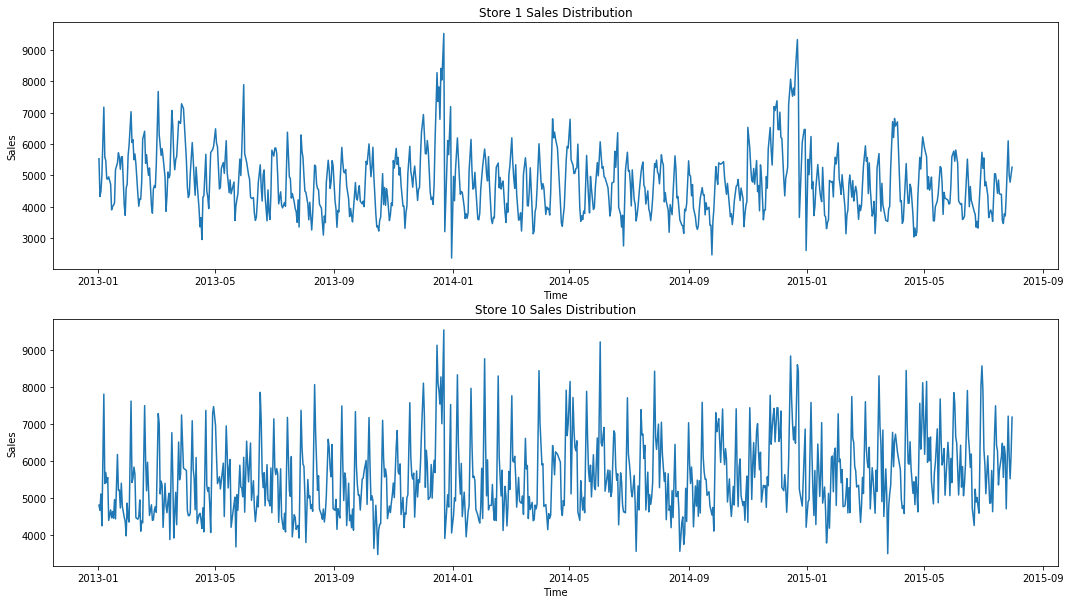

In [9]:
# draw store 1 and store 10 sales distribution plot
store_1 = train.loc[(train["Store"] == 1) & (train['Sales'] > 0), ['Date', "Sales"]]
store_10 = train.loc[(train["Store"]==10)&(train['Sales']>0), ['Date',"Sales"]]
f = plt.figure(figsize=(18,10))
ax1 = f.add_subplot(211)
ax1.plot(store_1['Date'], store_1['Sales'], '-')
ax1.set_xlabel('Time')
ax1.set_ylabel('Sales')
ax1.set_title('Store 1 Sales Distribution')

ax2 = f.add_subplot(212)
ax2.plot(store_10['Date'], store_10['Sales'], '-')
ax2.set_xlabel('Time')
ax2.set_ylabel('Sales')
ax2.set_title('Store 10 Sales Distribution')

In [10]:
test.head()
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

Text(0.5, 1.0, 'Store Daily Open Countplot')

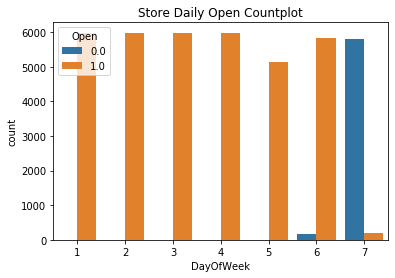

In [11]:
# check stores open distribution on days of week
sns.countplot(x='DayOfWeek', hue='Open', data=test)
plt.title('Store Daily Open Countplot')

In [12]:
# check missing values in test open column
test[test.Open.isnull()]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


In [13]:
# fill missing values in test with 1
test.fillna(value=1, inplace = True)

In [14]:
# merge data with store 
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

# split the last 6 weeks data as hold-out set (idea from Gert https://www.kaggle.com/c/rossmann-store-sales/discussion/18024)
train = train.sort_values(['Date'],ascending = False)
train_total = train.copy()

split_index = 6*7*1115
valid = train[:split_index] 
train = train[split_index:]

# only use data of Sales>0 and Open is 1
valid = valid[(valid.Open != 0)&(valid.Sales >0)]
train = train[(train.Open != 0)&(train.Sales >0)]
train_total = train_total[(train_total.Open != 0)&(train_total.Sales >0)]

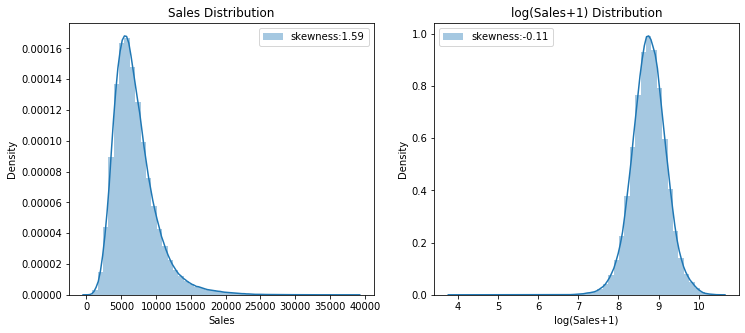

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# check distribution of sales in train set
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
g1 = sns.distplot(train['Sales'],hist = True,label='skewness:{:.2f}'.format(train['Sales'].skew()),ax = ax1)
g1.legend()
g1.set(xlabel = 'Sales', ylabel = 'Density', title = 'Sales Distribution')
g2 = sns.distplot(np.log1p(train['Sales']),hist = True,label='skewness:{:.2f}'.format(np.log1p(train['Sales']).skew()),ax=ax2)
g2.legend()
g2.set(xlabel = 'log(Sales+1)',ylabel = 'Density', title = 'log(Sales+1) Distribution')
plt.show()

In [16]:
# process train and test
def process(data, isTest = False):
    # label encode some features
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    # extract some features from date column  
    data['Month'] = data.Date.dt.month
    data['Year'] = data.Date.dt.year
    data['Day'] = data.Date.dt.day
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    # calculate competiter open time in months
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)
    
    # calculate promo2 open time in months
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data['PromoOpen'].apply(lambda x: x if x > 0 else 0)
                                                 
    # Indicate whether the month is in promo interval
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['month_str'] = data.Month.map(month2str)

    def check(row):
        if isinstance(row['PromoInterval'],str) and row['month_str'] in row['PromoInterval']:
            return 1
        else:
            return 0
        
    data['IsPromoMonth'] =  data.apply(lambda row: check(row),axis=1)    
    
    # select the features we need
    features = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']  
    if not isTest:
        features.append('Sales')
        
    data = data[features]
    return data

train = process(train)
valid = process(valid)
train_total = process(train_total)
x_test = process(test, isTest = True)   

In [17]:
# sort by index
valid.sort_index(inplace = True)
train.sort_index(inplace = True)
train_total.sort_index(inplace = True)

# split x and y
x_train, y_train = train.drop(columns = ['Sales']), np.log1p(train['Sales'])
x_valid, y_valid = valid.drop(columns = ['Sales']), np.log1p(valid['Sales'])
x_train_total, y_train_total = train_total.drop(columns = ['Sales']), np.log1p(train_total['Sales'])

In [18]:
# define eval metrics
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [19]:
# try random forest
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators = 15)
clf.fit(x_train, y_train)
# validation
y_pred = clf.predict(x_valid)
error = rmspe(np.expm1(y_valid), np.expm1(y_pred))
print('RMSPE: {:.4f}'.format(error))

RMSPE: 0.1604


Text(0.5, 1.0, 'Feature Importance')

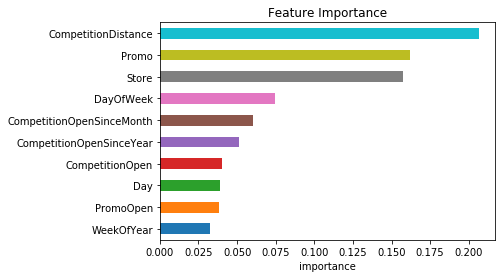

In [20]:
# plot feature importance for random forest model, show top 10 features
feat_importances = pd.Series(clf.feature_importances_, index=x_train.columns)
feat_importances.nlargest(10).sort_values(ascending = True).plot(kind='barh')
plt.xlabel('importance')
plt.title('Feature Importance')

In [ ]:
import xgboost as xgb

params = {
    "objective": "reg:linear", # for linear regression
          "booster" : "gbtree",   # use tree based models 
          "eta": 0.03,   # learning rate
          "max_depth": 10,    # maximum depth of a tree
          "subsample": 0.9,    # Subsample ratio of the training instances
          "colsample_bytree": 0.7,   # Subsample ratio of columns when constructing each tree
          "silent": 1,   # silent mode
          "seed": 0}
num_boost_round = 4000

dtrain = xgb.DMatrix(x_train, y_train)
dvalid = xgb.DMatrix(x_valid, y_valid)
dtest = xgb.DMatrix(x_test)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
# train the xgboost model
model = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds= 100, feval=rmspe_xg, verbose_eval=True)
preds = model.predict(dtest)

[0]	train-rmse:8.02084	eval-rmse:8.02798	train-rmspe:0.99981	eval-rmspe:0.99981
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.78061	eval-rmse:7.78796	train-rmspe:0.99971	eval-rmspe:0.99971
[2]	train-rmse:7.54764	eval-rmse:7.55548	train-rmspe:0.99959	eval-rmspe:0.99960
[3]	train-rmse:7.32169	eval-rmse:7.32944	train-rmspe:0.99944	eval-rmspe:0.99945
[4]	train-rmse:7.10271	eval-rmse:7.11046	train-rmspe:0.99927	eval-rmspe:0.99928
[5]	train-rmse:6.88997	eval-rmse:6.89825	train-rmspe:0.99906	eval-rmspe:0.99907
[6]	train-rmse:6.68382	eval-rmse:6.69206	train-rmspe:0.99880	eval-rmspe:0.99882
[7]	train-rmse:6.48385	eval-rmse:6.49228	train-rmspe:0.99850	eval-rmspe:0.99852
[8]	train-rmse:6.28985	eval-rmse:6.29861	train-rmspe:0.99814	eval-rmspe:0.99817
[9]	train-rmse:6.10178	eval-rmse:6.11035	train-rmspe:0.99773	eval-rmspe:0.99776
[10]	train-rmse:5.91925	eval-rmse:5.92767	train-rmspe:

[100]	train-rmse:0.45529	eval-rmse:0.44459	train-rmspe:0.36137	eval-rmspe:0.34017
[101]	train-rmse:0.44550	eval-rmse:0.43502	train-rmspe:0.35599	eval-rmspe:0.33446
[102]	train-rmse:0.43608	eval-rmse:0.42591	train-rmspe:0.35087	eval-rmspe:0.32902
[103]	train-rmse:0.42708	eval-rmse:0.41718	train-rmspe:0.34600	eval-rmspe:0.32381
[104]	train-rmse:0.41834	eval-rmse:0.40888	train-rmspe:0.34124	eval-rmspe:0.31888
[105]	train-rmse:0.40979	eval-rmse:0.40051	train-rmspe:0.33670	eval-rmspe:0.31387
[106]	train-rmse:0.40154	eval-rmse:0.39241	train-rmspe:0.33222	eval-rmspe:0.30904
[107]	train-rmse:0.39369	eval-rmse:0.38486	train-rmspe:0.32810	eval-rmspe:0.30454
[108]	train-rmse:0.38610	eval-rmse:0.37736	train-rmspe:0.32409	eval-rmspe:0.30008
[109]	train-rmse:0.37897	eval-rmse:0.37061	train-rmspe:0.32028	eval-rmspe:0.29613
[110]	train-rmse:0.37190	eval-rmse:0.36377	train-rmspe:0.31662	eval-rmspe:0.29212
[111]	train-rmse:0.36524	eval-rmse:0.35751	train-rmspe:0.31318	eval-rmspe:0.28850
[112]	train-rmse

[200]	train-rmse:0.19264	eval-rmse:0.20424	train-rmspe:0.24150	eval-rmspe:0.21821
[201]	train-rmse:0.19238	eval-rmse:0.20411	train-rmspe:0.24131	eval-rmspe:0.21818
[202]	train-rmse:0.19137	eval-rmse:0.20319	train-rmspe:0.24053	eval-rmspe:0.21728
[203]	train-rmse:0.19066	eval-rmse:0.20257	train-rmspe:0.24008	eval-rmspe:0.21672
[204]	train-rmse:0.19003	eval-rmse:0.20206	train-rmspe:0.23959	eval-rmspe:0.21634
[205]	train-rmse:0.18940	eval-rmse:0.20151	train-rmspe:0.23921	eval-rmspe:0.21586
[206]	train-rmse:0.18857	eval-rmse:0.20082	train-rmspe:0.23860	eval-rmspe:0.21523
[207]	train-rmse:0.18840	eval-rmse:0.20075	train-rmspe:0.23855	eval-rmspe:0.21526
[208]	train-rmse:0.18788	eval-rmse:0.20026	train-rmspe:0.23820	eval-rmspe:0.21488
[209]	train-rmse:0.18701	eval-rmse:0.19949	train-rmspe:0.23754	eval-rmspe:0.21414
[210]	train-rmse:0.18683	eval-rmse:0.19937	train-rmspe:0.23589	eval-rmspe:0.21414
[211]	train-rmse:0.18663	eval-rmse:0.19930	train-rmspe:0.23587	eval-rmspe:0.21425
[212]	train-rmse

[300]	train-rmse:0.15362	eval-rmse:0.17144	train-rmspe:0.19790	eval-rmspe:0.18749
[301]	train-rmse:0.15335	eval-rmse:0.17123	train-rmspe:0.19776	eval-rmspe:0.18726
[302]	train-rmse:0.15326	eval-rmse:0.17118	train-rmspe:0.19768	eval-rmspe:0.18726
[303]	train-rmse:0.15301	eval-rmse:0.17099	train-rmspe:0.19747	eval-rmspe:0.18702
[304]	train-rmse:0.15291	eval-rmse:0.17091	train-rmspe:0.19738	eval-rmspe:0.18693
[305]	train-rmse:0.15231	eval-rmse:0.17039	train-rmspe:0.19685	eval-rmspe:0.18630
[306]	train-rmse:0.15201	eval-rmse:0.17015	train-rmspe:0.19654	eval-rmspe:0.18606
[307]	train-rmse:0.15181	eval-rmse:0.17000	train-rmspe:0.19627	eval-rmspe:0.18590
[308]	train-rmse:0.15171	eval-rmse:0.16992	train-rmspe:0.19620	eval-rmspe:0.18581
[309]	train-rmse:0.15096	eval-rmse:0.16928	train-rmspe:0.19327	eval-rmspe:0.18508
[310]	train-rmse:0.15049	eval-rmse:0.16888	train-rmspe:0.19292	eval-rmspe:0.18464
[311]	train-rmse:0.15033	eval-rmse:0.16867	train-rmspe:0.19279	eval-rmspe:0.18441
[312]	train-rmse

[400]	train-rmse:0.12972	eval-rmse:0.15249	train-rmspe:0.16820	eval-rmspe:0.16655
[401]	train-rmse:0.12962	eval-rmse:0.15241	train-rmspe:0.16811	eval-rmspe:0.16645
[402]	train-rmse:0.12946	eval-rmse:0.15228	train-rmspe:0.16794	eval-rmspe:0.16628
[403]	train-rmse:0.12938	eval-rmse:0.15222	train-rmspe:0.16787	eval-rmspe:0.16624
[404]	train-rmse:0.12921	eval-rmse:0.15209	train-rmspe:0.16771	eval-rmspe:0.16609
[405]	train-rmse:0.12917	eval-rmse:0.15206	train-rmspe:0.16719	eval-rmspe:0.16605
[406]	train-rmse:0.12891	eval-rmse:0.15183	train-rmspe:0.16697	eval-rmspe:0.16580
[407]	train-rmse:0.12888	eval-rmse:0.15181	train-rmspe:0.16633	eval-rmspe:0.16578
[408]	train-rmse:0.12865	eval-rmse:0.15162	train-rmspe:0.16605	eval-rmspe:0.16558
[409]	train-rmse:0.12852	eval-rmse:0.15160	train-rmspe:0.16592	eval-rmspe:0.16562
[410]	train-rmse:0.12842	eval-rmse:0.15151	train-rmspe:0.16583	eval-rmspe:0.16550
[411]	train-rmse:0.12835	eval-rmse:0.15147	train-rmspe:0.16571	eval-rmspe:0.16548
[412]	train-rmse

[500]	train-rmse:0.11739	eval-rmse:0.14300	train-rmspe:0.14791	eval-rmspe:0.15594
[501]	train-rmse:0.11723	eval-rmse:0.14288	train-rmspe:0.14777	eval-rmspe:0.15581
[502]	train-rmse:0.11701	eval-rmse:0.14271	train-rmspe:0.14756	eval-rmspe:0.15561
[503]	train-rmse:0.11684	eval-rmse:0.14257	train-rmspe:0.14739	eval-rmspe:0.15546
[504]	train-rmse:0.11672	eval-rmse:0.14248	train-rmspe:0.14726	eval-rmspe:0.15534
[505]	train-rmse:0.11653	eval-rmse:0.14232	train-rmspe:0.14708	eval-rmspe:0.15516
[506]	train-rmse:0.11647	eval-rmse:0.14216	train-rmspe:0.14703	eval-rmspe:0.15496
[507]	train-rmse:0.11636	eval-rmse:0.14206	train-rmspe:0.14693	eval-rmspe:0.15485
[508]	train-rmse:0.11632	eval-rmse:0.14206	train-rmspe:0.14688	eval-rmspe:0.15485
[509]	train-rmse:0.11619	eval-rmse:0.14199	train-rmspe:0.14678	eval-rmspe:0.15476
[510]	train-rmse:0.11608	eval-rmse:0.14190	train-rmspe:0.14668	eval-rmspe:0.15465
[511]	train-rmse:0.11603	eval-rmse:0.14190	train-rmspe:0.14663	eval-rmspe:0.15465
[512]	train-rmse

[600]	train-rmse:0.10841	eval-rmse:0.13615	train-rmspe:0.13837	eval-rmspe:0.14807
[601]	train-rmse:0.10833	eval-rmse:0.13612	train-rmspe:0.13829	eval-rmspe:0.14806
[602]	train-rmse:0.10828	eval-rmse:0.13610	train-rmspe:0.13824	eval-rmspe:0.14803
[603]	train-rmse:0.10811	eval-rmse:0.13598	train-rmspe:0.13808	eval-rmspe:0.14789
[604]	train-rmse:0.10804	eval-rmse:0.13592	train-rmspe:0.13801	eval-rmspe:0.14782
[605]	train-rmse:0.10795	eval-rmse:0.13586	train-rmspe:0.13793	eval-rmspe:0.14775
[606]	train-rmse:0.10791	eval-rmse:0.13584	train-rmspe:0.13790	eval-rmspe:0.14773
[607]	train-rmse:0.10776	eval-rmse:0.13573	train-rmspe:0.13775	eval-rmspe:0.14760
[608]	train-rmse:0.10768	eval-rmse:0.13567	train-rmspe:0.13768	eval-rmspe:0.14754
[609]	train-rmse:0.10748	eval-rmse:0.13553	train-rmspe:0.13749	eval-rmspe:0.14737
[610]	train-rmse:0.10741	eval-rmse:0.13549	train-rmspe:0.13743	eval-rmspe:0.14731
[611]	train-rmse:0.10728	eval-rmse:0.13539	train-rmspe:0.13732	eval-rmspe:0.14721
[612]	train-rmse

[700]	train-rmse:0.10183	eval-rmse:0.13143	train-rmspe:0.12955	eval-rmspe:0.14266
[701]	train-rmse:0.10179	eval-rmse:0.13142	train-rmspe:0.12937	eval-rmspe:0.14265
[702]	train-rmse:0.10176	eval-rmse:0.13140	train-rmspe:0.12933	eval-rmspe:0.14262
[703]	train-rmse:0.10168	eval-rmse:0.13135	train-rmspe:0.12926	eval-rmspe:0.14256
[704]	train-rmse:0.10167	eval-rmse:0.13135	train-rmspe:0.12924	eval-rmspe:0.14257
[705]	train-rmse:0.10164	eval-rmse:0.13129	train-rmspe:0.12918	eval-rmspe:0.14250
[706]	train-rmse:0.10155	eval-rmse:0.13123	train-rmspe:0.12909	eval-rmspe:0.14243
[707]	train-rmse:0.10154	eval-rmse:0.13122	train-rmspe:0.12908	eval-rmspe:0.14242
[708]	train-rmse:0.10147	eval-rmse:0.13118	train-rmspe:0.12901	eval-rmspe:0.14238
[709]	train-rmse:0.10138	eval-rmse:0.13113	train-rmspe:0.12893	eval-rmspe:0.14231
[710]	train-rmse:0.10136	eval-rmse:0.13112	train-rmspe:0.12870	eval-rmspe:0.14230
[711]	train-rmse:0.10129	eval-rmse:0.13107	train-rmspe:0.12863	eval-rmspe:0.14225
[712]	train-rmse

[800]	train-rmse:0.09750	eval-rmse:0.12883	train-rmspe:0.11679	eval-rmspe:0.13976
[801]	train-rmse:0.09741	eval-rmse:0.12877	train-rmspe:0.11670	eval-rmspe:0.13969
[802]	train-rmse:0.09736	eval-rmse:0.12875	train-rmspe:0.11665	eval-rmspe:0.13967
[803]	train-rmse:0.09732	eval-rmse:0.12873	train-rmspe:0.11661	eval-rmspe:0.13964
[804]	train-rmse:0.09727	eval-rmse:0.12870	train-rmspe:0.11657	eval-rmspe:0.13962
[805]	train-rmse:0.09725	eval-rmse:0.12870	train-rmspe:0.11632	eval-rmspe:0.13962
[806]	train-rmse:0.09723	eval-rmse:0.12871	train-rmspe:0.11630	eval-rmspe:0.13962
[807]	train-rmse:0.09720	eval-rmse:0.12868	train-rmspe:0.11624	eval-rmspe:0.13960
[808]	train-rmse:0.09718	eval-rmse:0.12867	train-rmspe:0.11563	eval-rmspe:0.13958
[809]	train-rmse:0.09714	eval-rmse:0.12870	train-rmspe:0.11558	eval-rmspe:0.13961
[810]	train-rmse:0.09712	eval-rmse:0.12869	train-rmspe:0.11558	eval-rmspe:0.13960
[811]	train-rmse:0.09709	eval-rmse:0.12867	train-rmspe:0.11555	eval-rmspe:0.13958
[812]	train-rmse

[900]	train-rmse:0.09384	eval-rmse:0.12730	train-rmspe:0.10973	eval-rmspe:0.13811
[901]	train-rmse:0.09379	eval-rmse:0.12727	train-rmspe:0.10967	eval-rmspe:0.13807
[902]	train-rmse:0.09374	eval-rmse:0.12724	train-rmspe:0.10962	eval-rmspe:0.13804
[903]	train-rmse:0.09373	eval-rmse:0.12722	train-rmspe:0.10961	eval-rmspe:0.13800
[904]	train-rmse:0.09370	eval-rmse:0.12721	train-rmspe:0.10955	eval-rmspe:0.13800
[905]	train-rmse:0.09363	eval-rmse:0.12717	train-rmspe:0.10949	eval-rmspe:0.13795
[906]	train-rmse:0.09362	eval-rmse:0.12716	train-rmspe:0.10947	eval-rmspe:0.13794
[907]	train-rmse:0.09360	eval-rmse:0.12715	train-rmspe:0.10945	eval-rmspe:0.13792
[908]	train-rmse:0.09359	eval-rmse:0.12714	train-rmspe:0.10944	eval-rmspe:0.13792
[909]	train-rmse:0.09355	eval-rmse:0.12713	train-rmspe:0.10938	eval-rmspe:0.13791
[910]	train-rmse:0.09352	eval-rmse:0.12711	train-rmspe:0.10936	eval-rmspe:0.13788
[911]	train-rmse:0.09346	eval-rmse:0.12707	train-rmspe:0.10929	eval-rmspe:0.13784
[912]	train-rmse

[1000]	train-rmse:0.09082	eval-rmse:0.12615	train-rmspe:0.10594	eval-rmspe:0.13689
[1001]	train-rmse:0.09079	eval-rmse:0.12614	train-rmspe:0.10592	eval-rmspe:0.13686
[1002]	train-rmse:0.09077	eval-rmse:0.12613	train-rmspe:0.10589	eval-rmspe:0.13685


In [ ]:
# validation
y_pred = model.predict(xgb.DMatrix(x_valid))
error = rmspe(np.expm1(y_valid), np.expm1(y_pred))
print('RMSPE: {:.4f}'.format(error))

In [ ]:
# rmspe correction on the whole
def correction():
    weights = np.arange(0.98, 1.02, 0.005)
    errors = []
    for w in weights:
        error = rmspe(np.expm1(y_valid), np.expm1(y_pred*w))
        errors.append(error)
        
    # make line plot
    plt.plot(weights, errors)
    plt.xlabel('weight')
    plt.ylabel('RMSPE')
    plt.title('RMSPE Curve')
    # print min error
    idx = errors.index(min(errors))
    print('Best weight is {}, RMSPE is {:.4f}'.format(weights[idx], min(errors)))
    
correction()

In [ ]:
x_train_total.head().append(x_train_total.tail())

In [ ]:
# print(x_train_total.shape)
# print(y_train_total.shape)

In [ ]:
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [ ]:
# dtrain = xgb.DMatrix(x_train_total, y_train_total)
# dtest = xgb.DMatrix(x_test)
# # specify parameters via map
# params = {"objective": "reg:linear", # for linear regression
#           "booster" : "gbtree",   # use tree based models 
#           "eta": 0.03,   # learning rate
#           "max_depth": 10,    # maximum depth of a tree
#           "subsample": 0.9,    # Subsample ratio of the training instances
#           "colsample_bytree": 0.7,   # Subsample ratio of columns when constructing each tree
#           "silent": 1,   # silent mode
#           "seed": 10   # Random number seed
#           }
# num_round = 3000
# model = xgb.train(params, dtrain, num_round, early_stopping_rounds=50)
# # make prediction
# preds = model.predict(dtest)

In [ ]:
# make submission using best weight
result = pd.DataFrame({"Id": test["Id"],'Sales': np.expm1(preds*0.995)})
result.to_csv("submission_xgb.csv", index=False)

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(8,8))
xgb.plot_importance(model, max_num_features= 10, height=0.5, ax=ax)
plt.show()